In [1]:
# packages
import pandas as pd
import numpy as np

from claspy.segmentation import BinaryClaSPSegmentation

import ruptures as rpt

import stumpy
from aeon.segmentation import find_dominant_window_sizes

from aeon.segmentation import GreedyGaussianSegmenter

from aeon.segmentation import InformationGainSegmenter

from aeon.anomaly_detection import STRAY

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer,mean_squared_error
from ruptures.metrics import precision_recall
import matplotlib.pyplot as plt
from aeon.visualisation import plot_series_with_change_points, plot_series_with_profiles
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

from claspy.tests.evaluation import f_measure,covering

C:\Users\tikyn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\aeon\base\__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [2]:
def f1scoremargin(ground_truth, predictions, tolerance):
    """
    Calcola l'F1 score con una finestra di tolleranza sui change points.
    
    :param ground_truth: Lista o array di change points reali
    :param predictions: Lista o array di change points predetti
    :param tolerance: La tolleranza temporale (numero di unità temporali)
    :return: precision, recall, f1-score
    """
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    
    # Vettori per tracciare quali punti sono stati già associati
    matched_ground_truth = np.zeros(len(ground_truth), dtype=bool)
    matched_predictions = np.zeros(len(predictions), dtype=bool)

    mgt={key: False for key in ground_truth}
    mcp={key: False for key in predictions}
    #print(f'gt:{len(ground_truth)} - cp:{len(predictions)}')
    # True Positives (TP)
    tp = 0
    for i, gt_point in enumerate(ground_truth):
        for j, pred_point in enumerate(predictions):
            if not matched_predictions[j] and abs(gt_point - pred_point) <= tolerance:
                tp += 1
                matched_ground_truth[i] = True
                matched_predictions[j] = True

                mgt[gt_point] = True
                mcp[pred_point] = True
                break
            
    
    # False Positives (FP) - predizioni non corrispondenti a nessun ground truth entro la tolleranza
    fp = np.sum(~matched_predictions)
    
    # False Negatives (FN) - punti del ground truth non corrispondenti a nessuna predizione entro la tolleranza
    fn = np.sum(~matched_ground_truth)
    #print(f'tp:{tp} - fp:{fp} - fn:{fn}')
    #print(mgt)
    #print(mcp)
    # Calcolo di precision, recall e F1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

In [3]:
# Questi sono tutte le features estratte
# kineticglobal,kineticchest,directnesshead,density,leftwristke,rightwristke,leftankleke,rightankleke,headke,posturaltension

# Queste sono le feature che utilizzeremo
# kineticglobal, density, leftwirstke, rightwristke, leftankleke, rightankleke, headke, posturaltension
# che corrispondono
# 2,4,5,6,7,8,9,10,11
# Questa funzione legge il file di input e restituisce un dataframe con i dati preprocessati
def ReadAndPreProcess(inputDataRaw):
    # lettura
    df=pd.read_csv(inputDataRaw,sep=' ', header=None)
    df.drop(0, axis=1)
    df["som"]=df.sum(axis=1)
    ## preprocessing

    # dealing NaN values
    #-serafino ha usato forward fill, backward fill, linear interpolation
    #-ricordo che serafino aveva gia utilizzato sta cosa sui dati grezzi non sulle feature ma sui dati prefeature percio dovrebbe essere gia apposto

    # downsampling
    #-sono a 100ms, non sò se devo scendere a 50ms. da decidere
    #-non lo faccio xk non mi interessa se va piu lento, guarda su notion per ulteriori informazioni

    # low pass filter
    #-Skogstad and colleagues (2013) e https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
    #-implementare dopo

    # remove outliers
    #-utilizzare hampel filter

    # stretch
    #-forse devo stretcharlo come ho fatto precedentemente
    #-anche se nel codice precedente ho stretchato solo il groundtruth

    # ritorno un oggetto dataframe dopo che è stato lavorato, ottenendo un prodotto lavorato
    return df


In [4]:
# questa funzione ritorna un dataframe del groundtruth che viene usato specificatamente per visualizzare il gt
# è soggetto a un preprocessing dei dati siccome l'ultimo groundtruth è dove termina il ts del gt
# di conseguenza per farlo corrispondere, bisogna stretcharlo
# ma ricordo di aver rifatti i dati nuovi per generare un groundtruth a fine ts, da controllare cosi che non serve stretcharlo?
def LoadingGroundTruth(df,gtraw):
    gt=pd.read_csv(gtraw,sep=' ', header=None)
    gt=gt.iloc[:,0].values
    #stretching dei dati se necessario per farlo corrispondere alla ts dei dati
    stretch_gt = np.array([])
    for idx,i in enumerate(gt):
        relpos = len(df)*i/gt[-1]
        stretch_gt = np.append(stretch_gt,relpos)

    # eliminiamo l'ultimo elemento che è stato annotato solo per delimitare la lunghezza della gt simile alla ts
    return stretch_gt[:-1]

In [5]:
# utilizzo CLASP 
# prende come parametro un dataframe e restituisce il clasp score
# gt e known vengono usati per usare il numero vero di cp se uguale a 1 sennò si cerca di predirlo se il modello lo permette
def GetClasp(df,gt,known, **kwargs):
    
    result=np.array([])
    eachresult = []
    eachclasp=[]
    for idx,i in enumerate([2,4,5,6,7,8,9,10,11]):
      
        ts=df.iloc[:,i]
        clasp = BinaryClaSPSegmentation(**kwargs)
        found_cps = clasp.fit_predict(ts.values)    

        # c'è un bug con binseg dove un cp è oltre la lunghezza del ts
        # faccio un loop e se eccede cambio il valore con la len(tf)-1
        for i in range(0,len(found_cps)):
            if found_cps[i] >= len(ts):
                found_cps[i] = len(ts)-1

        # per ogni array di cp di ogni singola feature
        # li unisco in un unico array. in pratica faccio un OR di tutti i cp
        result = np.sort(np.append(result,found_cps).flatten())
        result = np.unique(result)
        eachresult.append(found_cps)
        eachclasp.append(clasp)
        
        

        
    return result, eachresult, eachclasp
        
    


In [6]:
# calcola i vari scores dati il groundtruth e il prediction
# puo salvare il risultato su file per evitare di perderli
# prende come parametro nome del groundtruth, groundtruth, nome della timeseries e il prediction
def Evaluate(modelName,gtName, gt, tsName, cp, df, margin,msg, nomeFile):
    # creo dei array di lunghezza come la ts cosi possono fare il confronto
    # sia per il gt che per il pd
  
    cpnump = np.array(cp)
    gtnump = np.array(gt)

    cp_long = np.zeros(len(df)+1)
    cp_long[cpnump.astype(int)]=1

    gt_long = np.zeros(len(df)+1)
    gt_long[gtnump.astype(int)]=1

    # calcolo lo score 
    print(f'f1margin: {f1scoremargin(gt.astype(int),cp.astype(int),margin)}')
    precision,recall,f1=f1scoremargin(gt.astype(int),cp.astype(int),margin)
     #scrivo su file il risultato
    f = open("outputFile/ClaSPallresult", "a")
    f.write(nomeFile+"\n")
    f.write(msg+"\n")
    f.write("precision:"+str(precision)+" recall:"+str(recall)+" f1:"+str(f1)+" \n")
    f.write("\n")
    f.close()

In [ ]:
def Plotclasp(eachclasp,gt,margin,eachcp,nomeFile):
    
    for idx,clasp in enumerate(eachclasp):
        clasp.plot(gt_cps=gt.astype(int), heading=f'f1margin: {f1scoremargin(gt.astype(int),eachcp[idx].astype(int),margin)} {nomeFile}', ts_name="suss", file_path="segmentation_example.png")


    
        for idx2,j in enumerate(gt.astype(int)):
            plt.fill_betweenx(np.array([0, 1]), j-margin, j+margin, color='green', alpha=0.3)


In [7]:
def PlotResult(df,gt,cp):
    #da testare quando ho piu valori
    #clasp.plot(gt_cps=gt.astype(int), heading="Segmentation of different umpire cricket signals", ts_name="ACC", file_path="segmentation_example.png")

    plt.figure(figsize=(18,9))
    plt.plot(np.arange(len(df["som"].values)),df["som"].values,'blue',linewidth=0.5)
    for idx2,j in enumerate(gt.astype(int)):

            plt.axvline(x = j, color = 'green',linewidth=1) 
            
    for j in cp.tolist():
        plt.axvline(x = j, color = 'red',linewidth=1,linestyle="-.") 
    



In [8]:
#questi sono i dataset comprendente le timeseries e il groundtruth
timeseries=[#"in\cora1_input.txt",
      #"in\cora4_input.txt",
    "in\cora1_input.txt",
      "in\cora4_input.txt",
      "in\cora5_input.txt",
      "in\cora14_input.txt",
      "in\cora14_input.txt",
      "in\marianne7_input.txt",
      "in\marianne8_input.txt",
      "in\marianne10_input.txt",
      "in\marianne18_input.txt",
      "in\marianne19_input.txt",
      "in\marianne24_input.txt",
      "in\marianne26_input.txt",
      "in\marianne41_input.txt",
      "in\marianne42_input.txt",
      "in\marianne43_input.txt",
      "in\marianne47_input.txt",
      "in\marianne48_input.txt",
      "in\marianne48_input.txt",
      "in\muriel18_input.txt",
      "in\muriel26_input.txt",
      "in\muriel27_input.txt",
      "in\muriel30_input.txt"

      ]
groundtruth=[#"gt\cora_gt_2019-08-08_t001_video01.txt",
         #"gt\cora_gt_2019-08-08_t004_video01.txt",
            "gt\cora_gt_2019-08-08_t001_video01.txt",
         "gt\cora_gt_2019-08-08_t004_video01.txt",
         "gt\cora5_gt.txt",
         "gt\cora_gt_2019-08-08_t014_video01.txt",
         "gt\marianne_gt_2016-03-22_t007_video01.txt",
         "gt\marianne_gt_2016-03-22_t008_video01.txt",
         "gt\marianne_gt_2016-03-22_t010_video01.txt",
         "gt\marianne_gt_2016-03-22_t018_video01.txt",
         "gt\marianne_gt_2016-03-22_t019_video01.txt",
         "gt\marianne_gt_2016-03-22_t024_video01.txt",
         "gt\marianne_gt_2016-03-22_t026_video01.txt",
         "gt\marianne_gt_2016-03-22_t041_video01.txt",
         "gt\marianne_gt_2016-03-22_t042_video01.txt",
         "gt\marianne_gt_2016-03-22_t043_video01.txt",
         "gt\marianne_gt_2016-03-22_t047_video01.txt",
         "gt\marianne_gt_2016-03-22_t048_video01.txt",
         "gt\marianne_gt_2016-03-22_t048_video01.txt",
         "gt\muriel_gt_2016-03-21_t014_video01.txt",
         "gt\muriel_gt_2016-03-21_t018_video01.txt",
         "gt\muriel_gt_2016-03-21_t026_video01.txt",
         "gt\muriel_gt_2016-03-21_t027_video01.txt",
         "gt\muriel_gt_2016-03-23_t029_video01.txt",
         "gt\muriel_gt_2016-03-23_t030_video01.txt",
         "gt\muriel_gt_2016-03-23_t030_video01.txt"
         ]



0


C:\Users\tikyn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\claspy\nearest_neighbour.py:240: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  start, end = pranges[idx]


f1margin: (1.0, 0.0625, 0.11764705882352941)
1
f1margin: (0, 0.0, 0)
2


C:\Users\tikyn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\claspy\segmentation.py:206: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(


f1margin: (0.7, 0.8235294117647058, 0.7567567567567567)
3
f1margin: (1.0, 0.04, 0.07692307692307693)
4
f1margin: (1.0, 0.047619047619047616, 0.0909090909090909)
5
f1margin: (1.0, 0.07407407407407407, 0.13793103448275862)
6
f1margin: (1.0, 0.038461538461538464, 0.07407407407407407)
7
f1margin: (0, 0.0, 0)
8
f1margin: (1.0, 0.022222222222222223, 0.04347826086956522)
9
f1margin: (1.0, 0.045454545454545456, 0.08695652173913045)
10
f1margin: (1.0, 0.047619047619047616, 0.0909090909090909)
11
f1margin: (0, 0.0, 0)
12


C:\Users\tikyn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\claspy\segmentation.py:206: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(


f1margin: (0, 0.0, 0)
13
f1margin: (0.3333333333333333, 0.02564102564102564, 0.047619047619047616)
14
f1margin: (0.0, 0.0, 0)
15


C:\Users\tikyn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\claspy\segmentation.py:206: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(


f1margin: (0, 0.0, 0)
16
f1margin: (1.0, 0.058823529411764705, 0.1111111111111111)
17
f1margin: (1.0, 0.023255813953488372, 0.04545454545454545)
18
f1margin: (0.8571428571428571, 0.17142857142857143, 0.2857142857142857)
19
f1margin: (0.0, 0.0, 0)
20


C:\Users\tikyn\AppData\Local\Temp\ipykernel_9832\4139422699.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18,9))


f1margin: (0, 0.0, 0)
21
f1margin: (1.0, 0.05970149253731343, 0.11267605633802817)


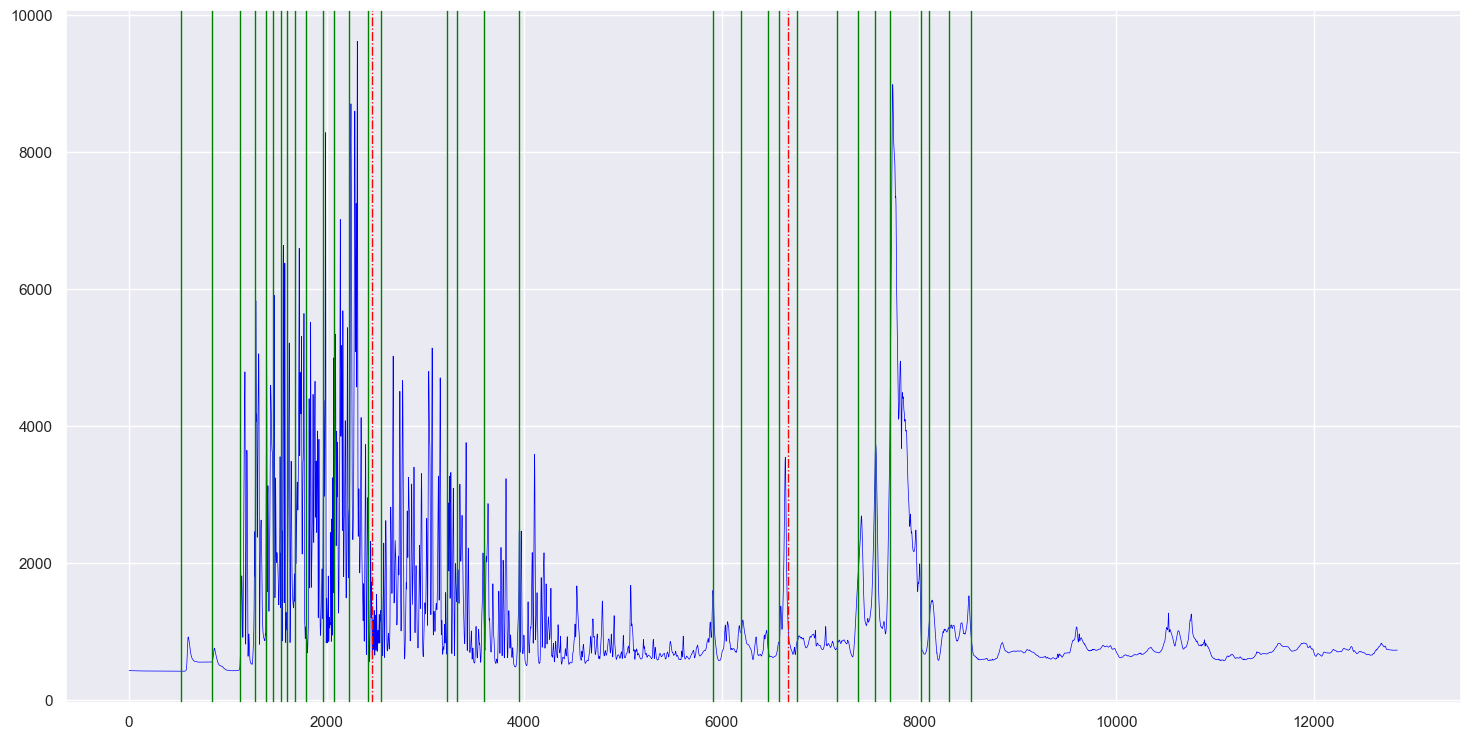

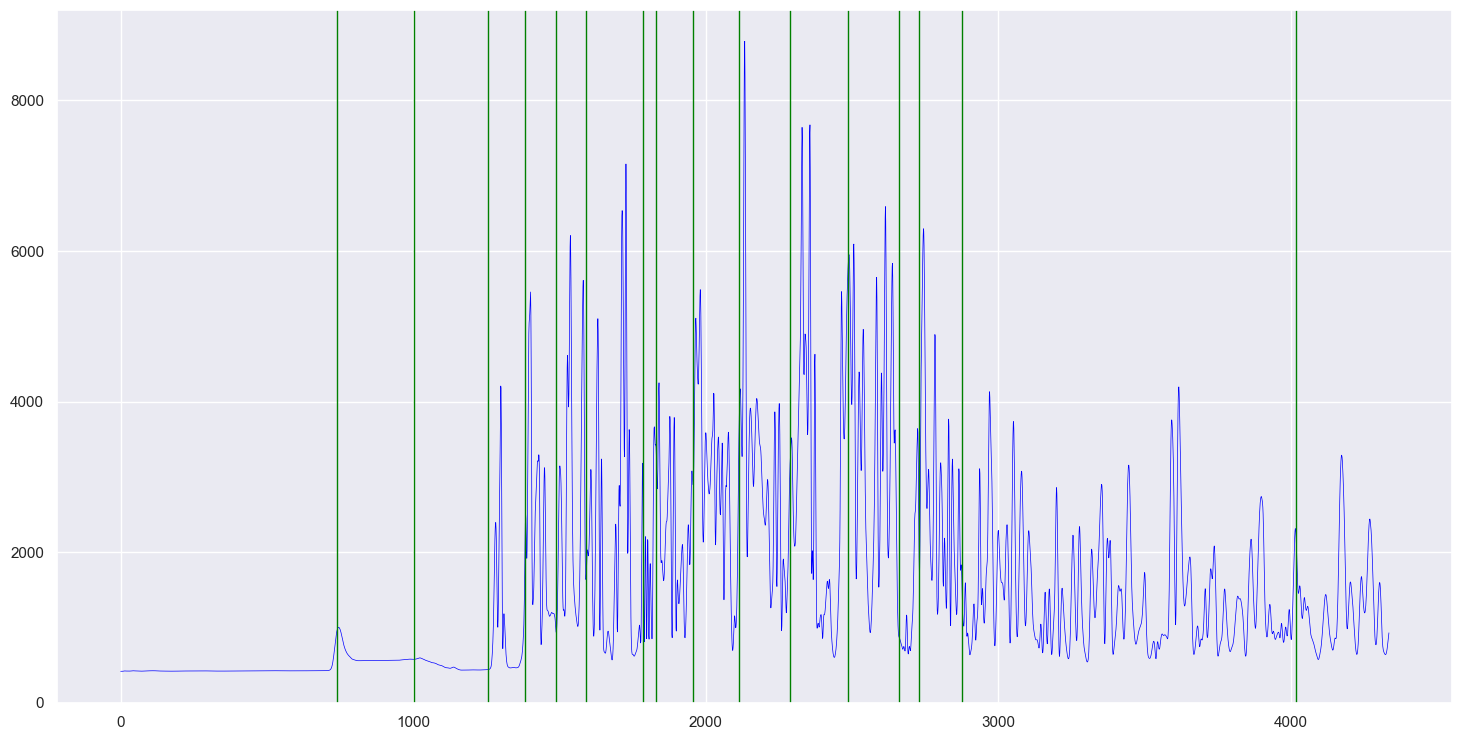

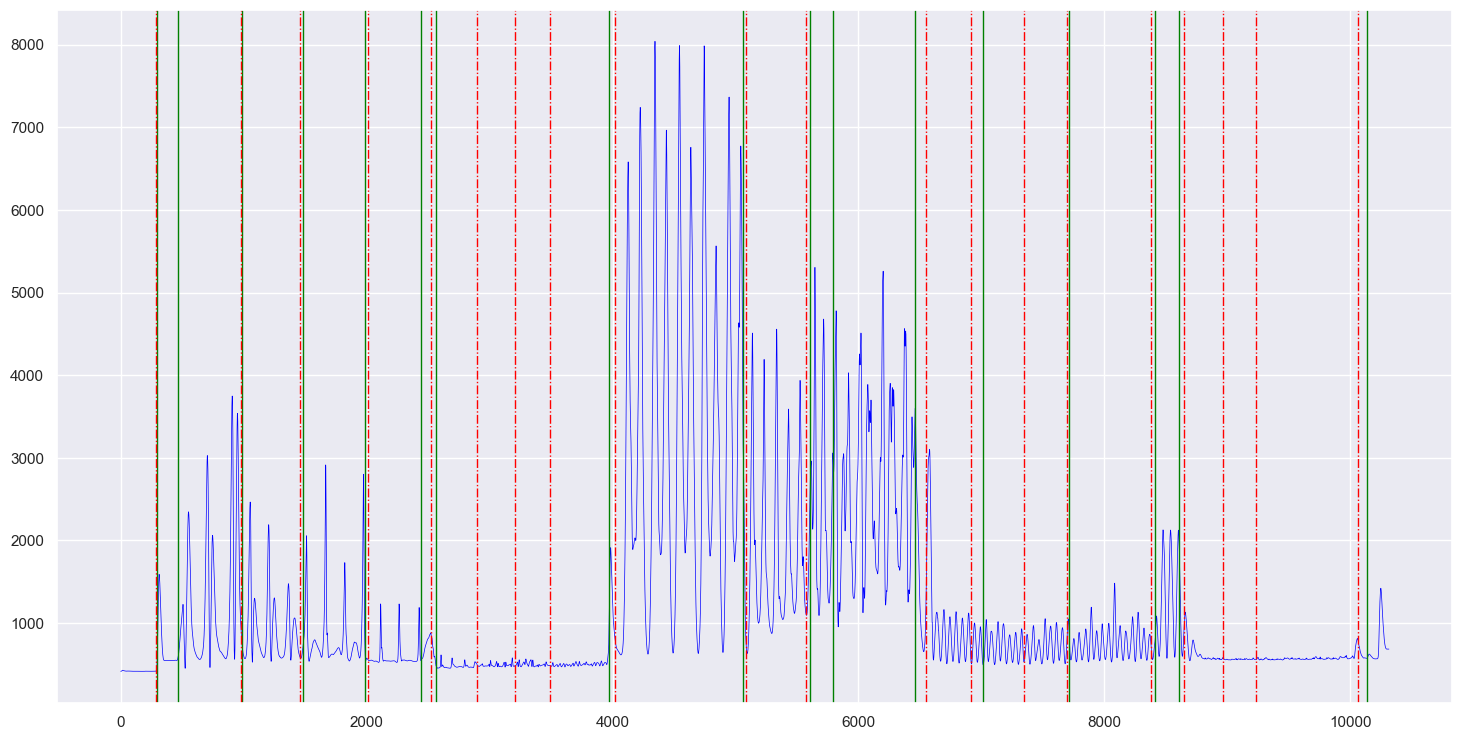

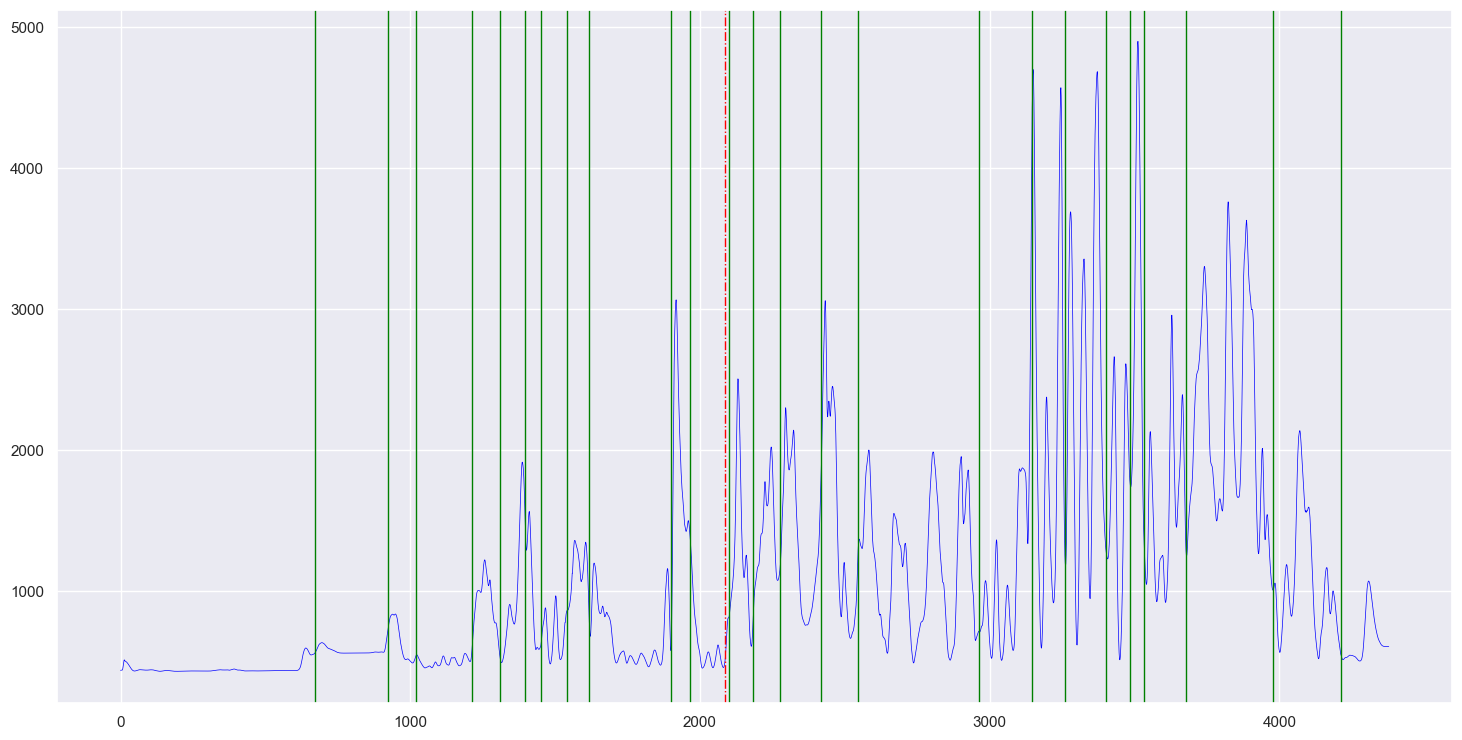

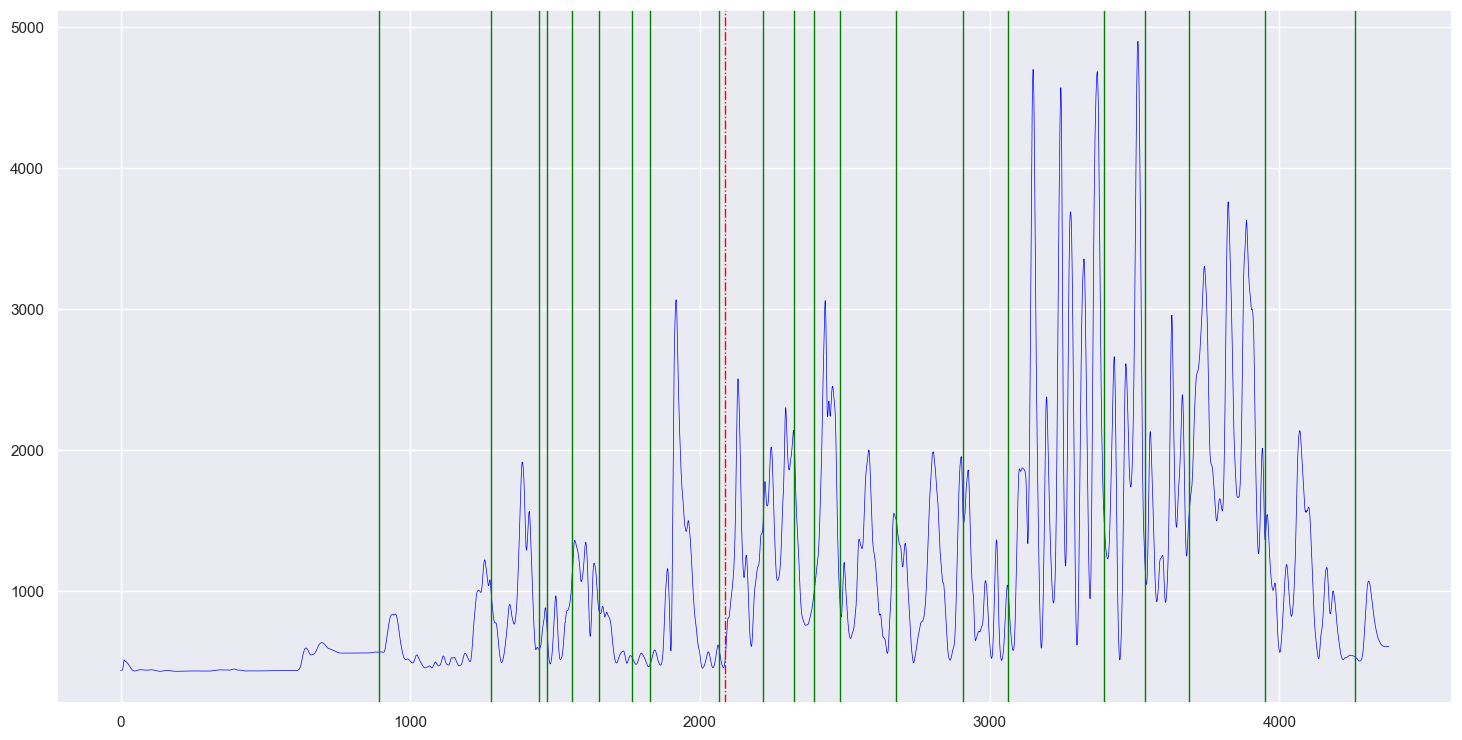

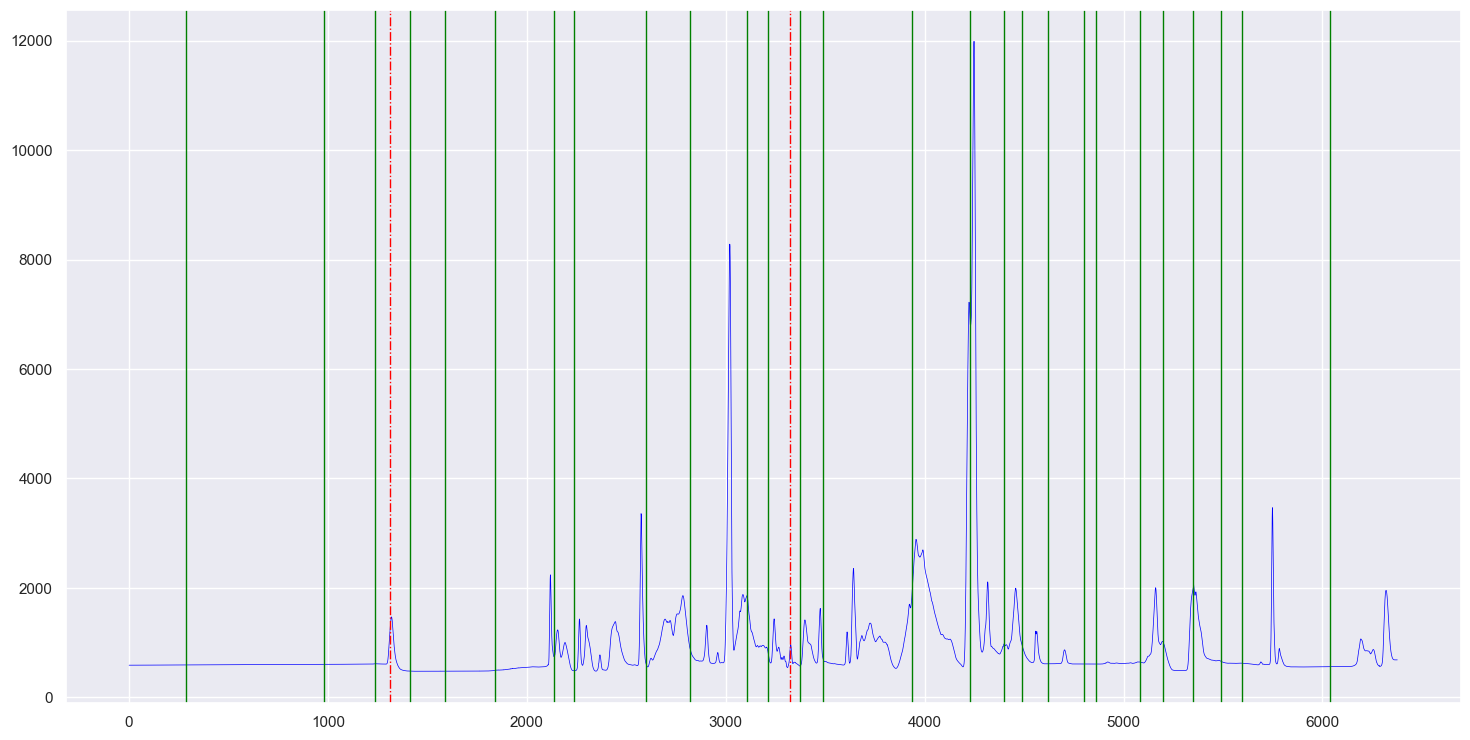

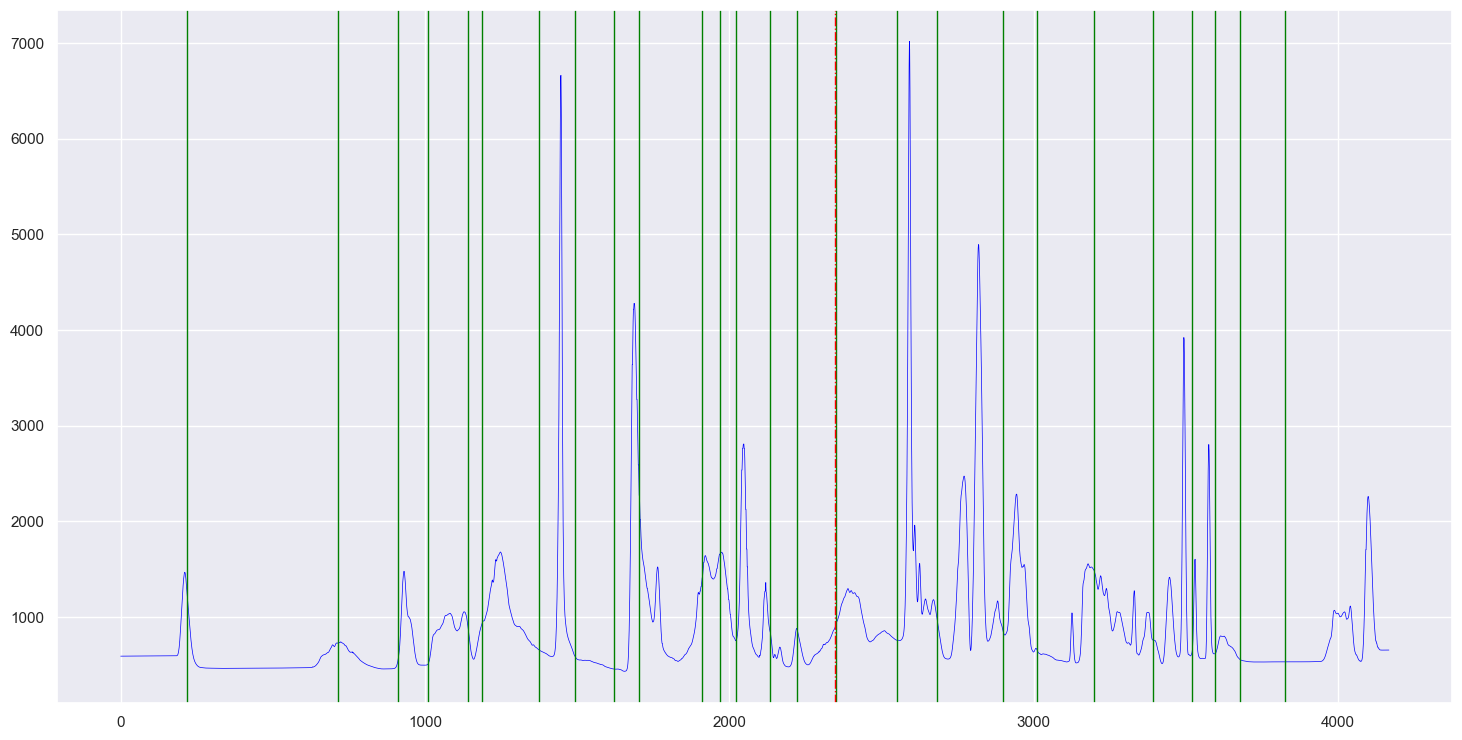

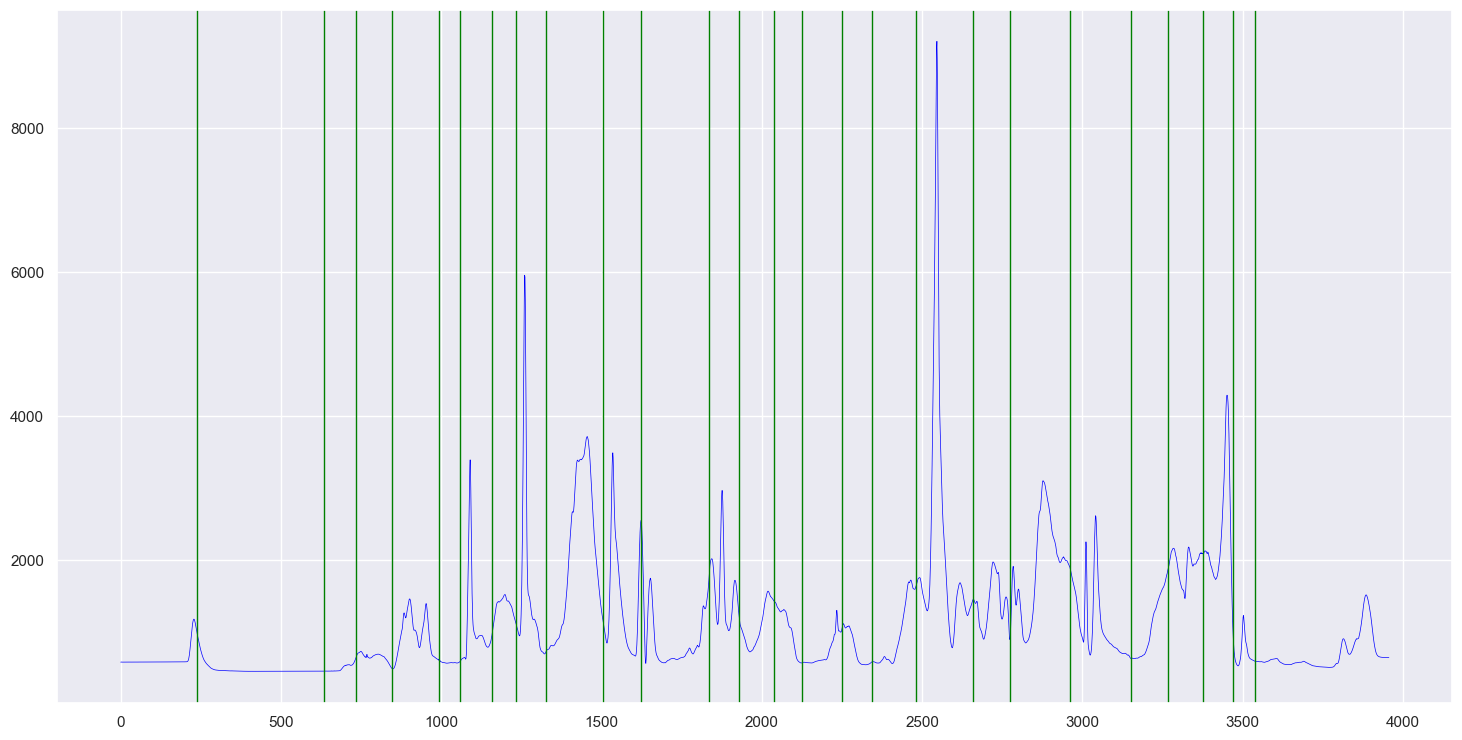

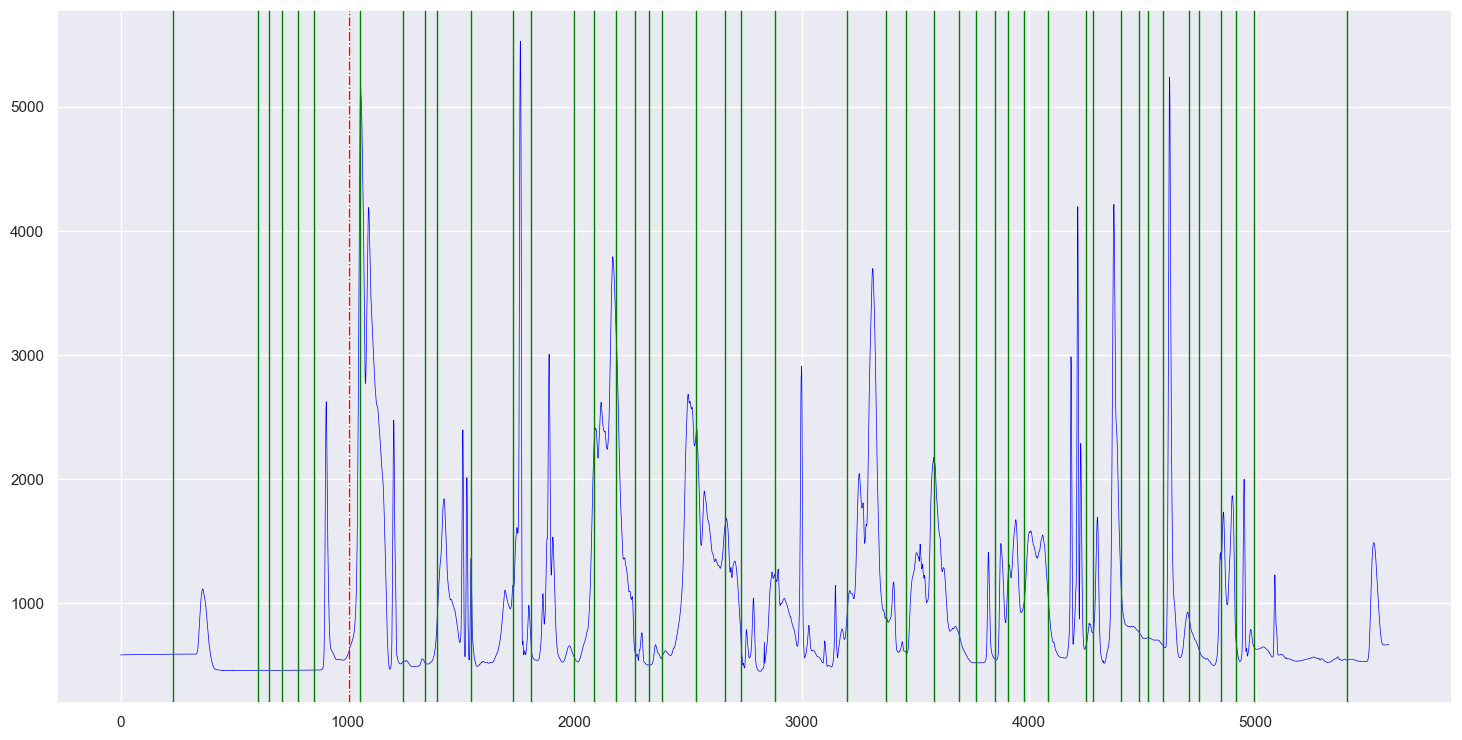

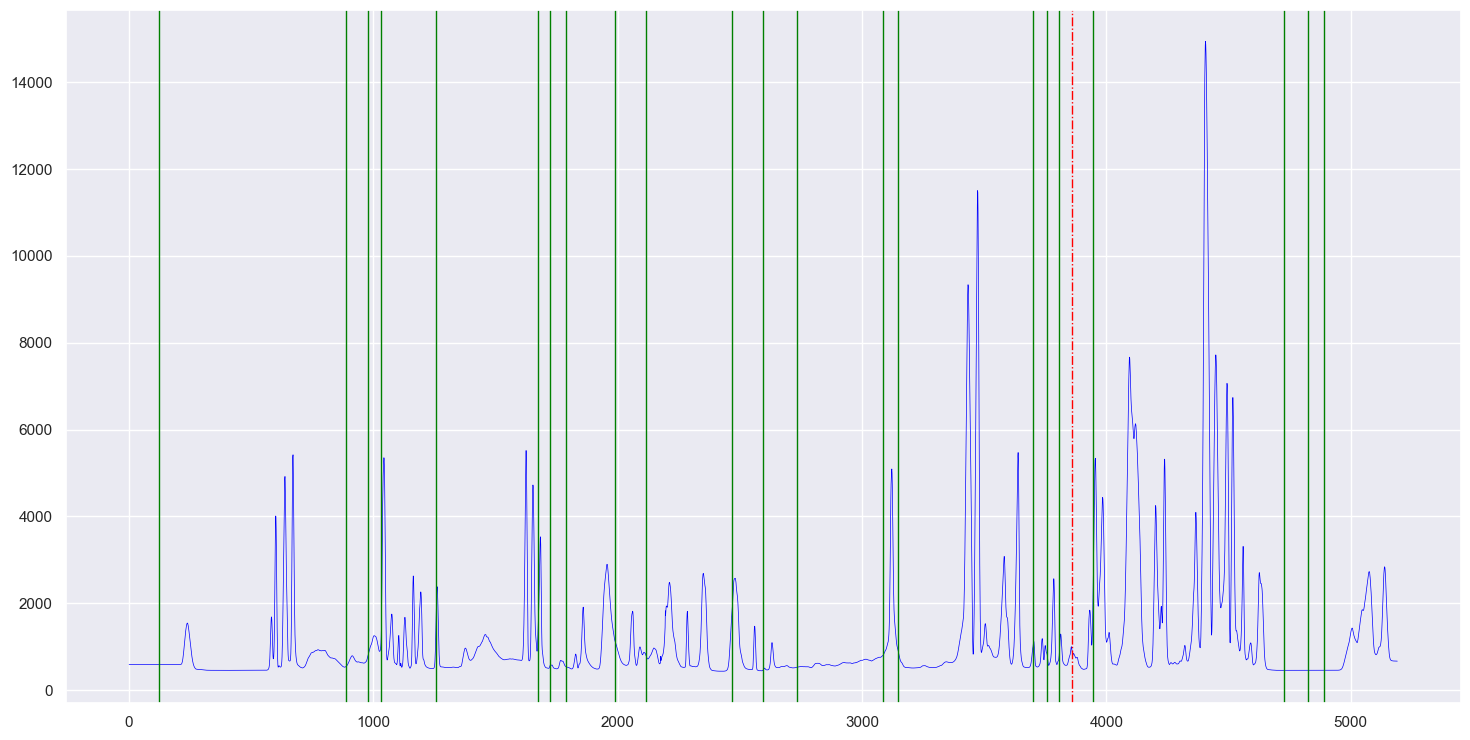

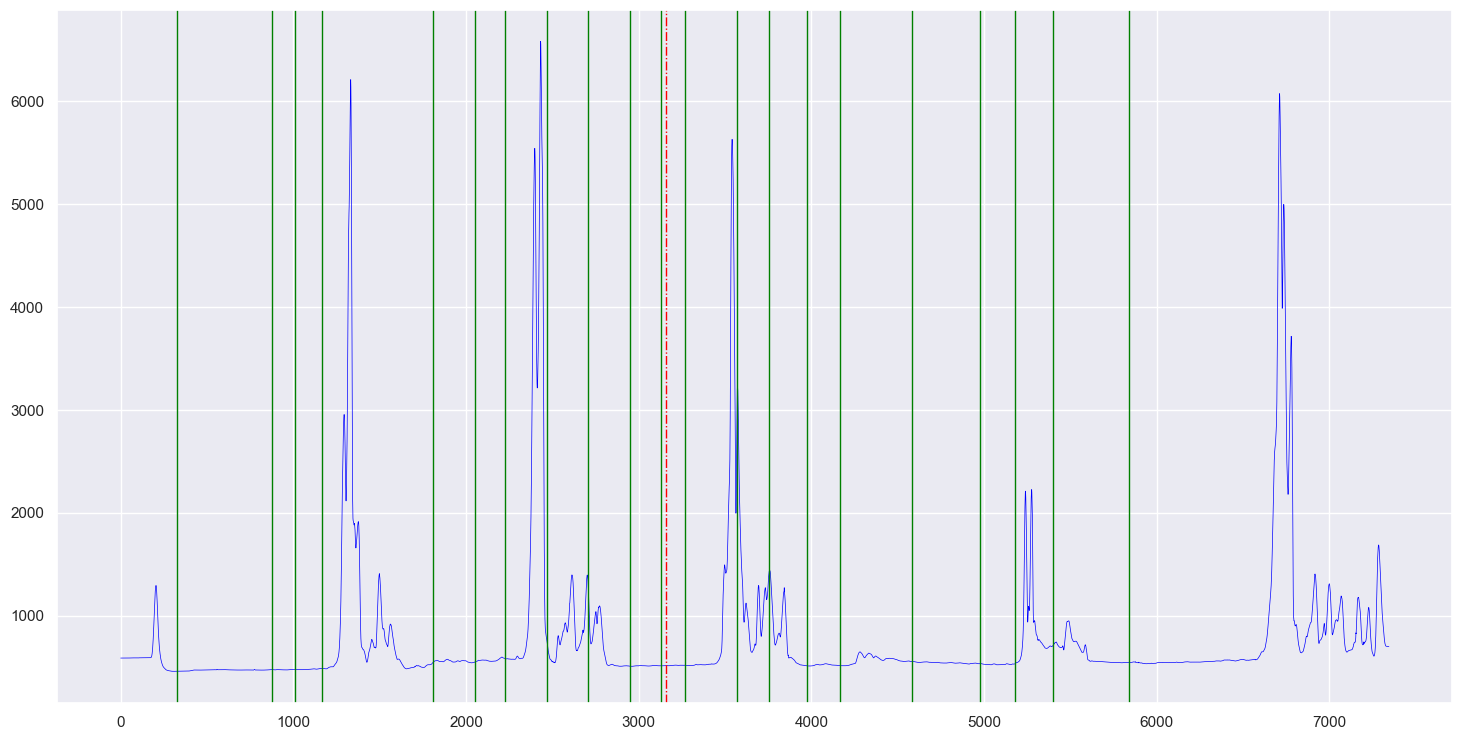

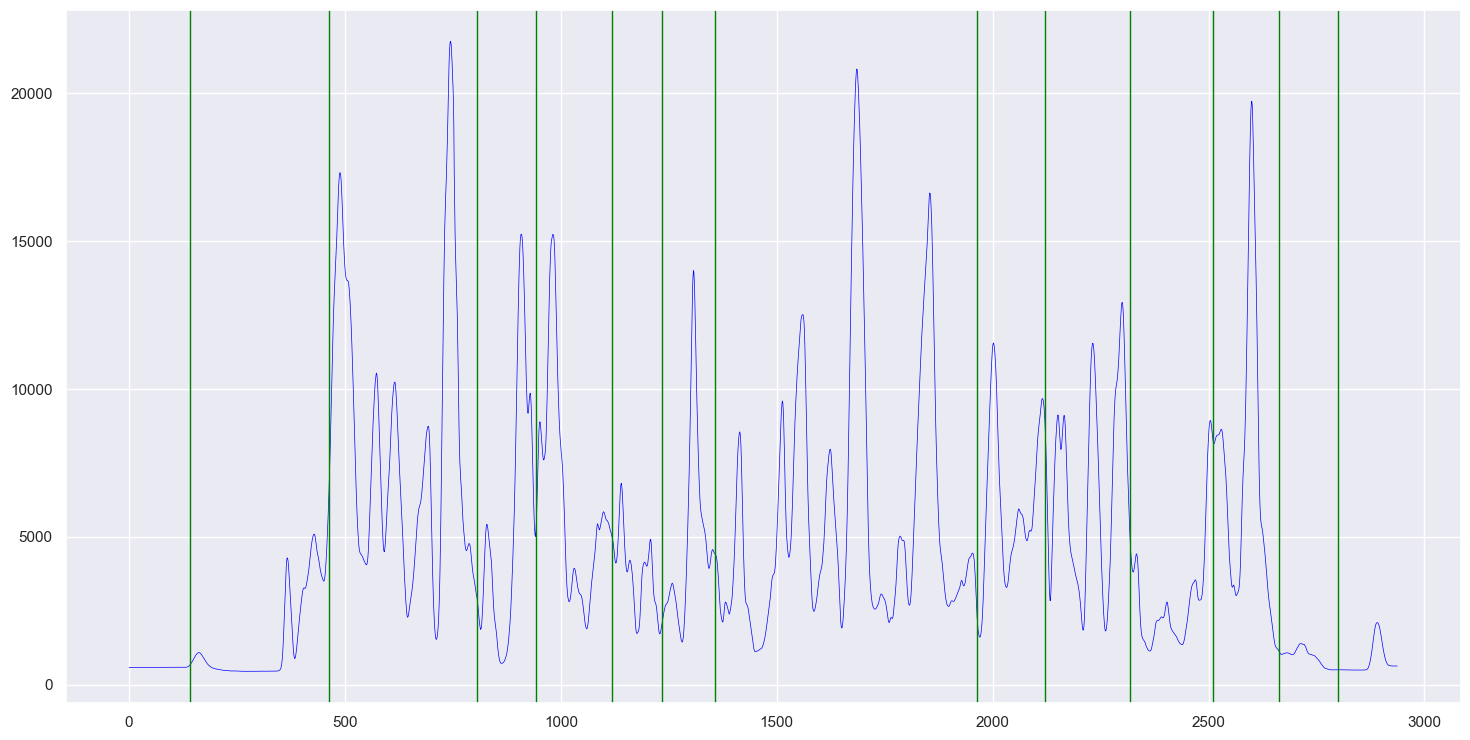

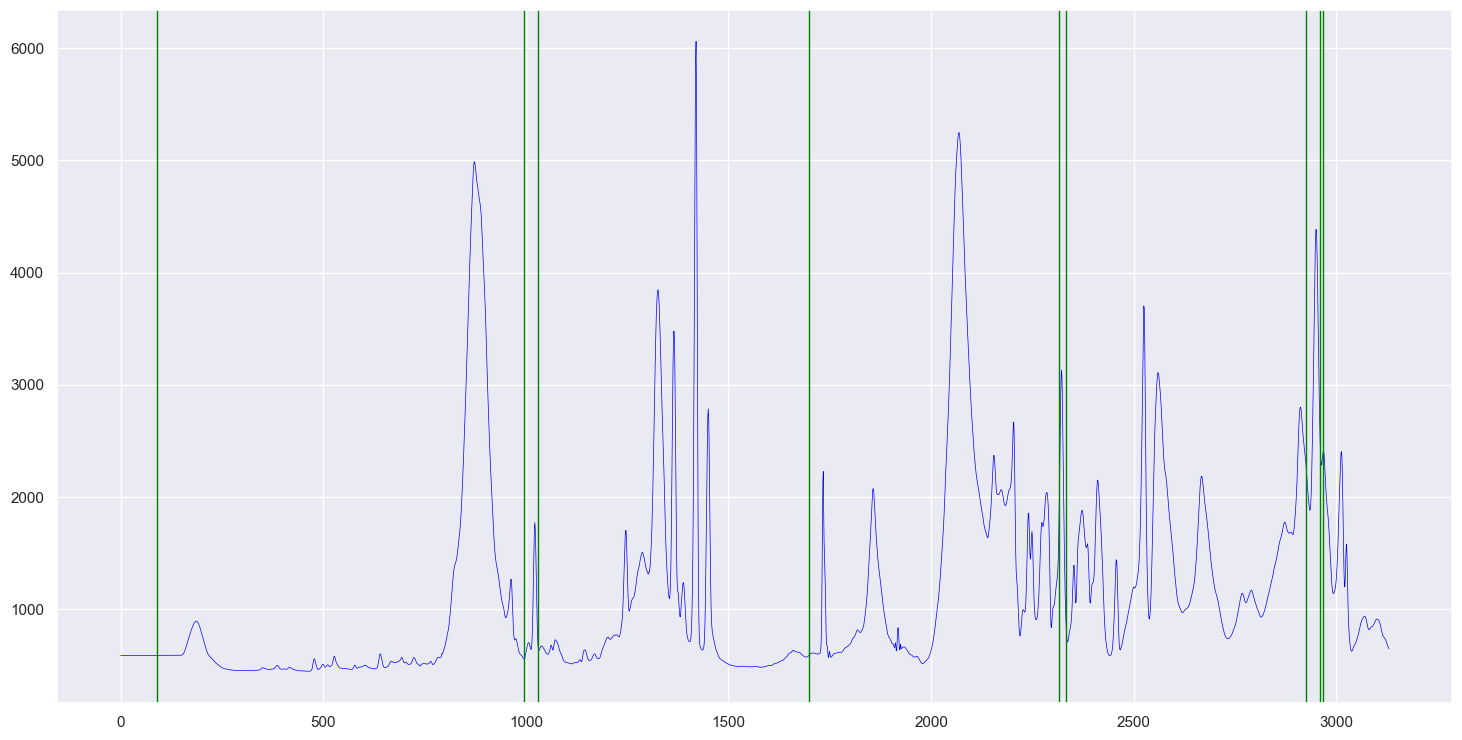

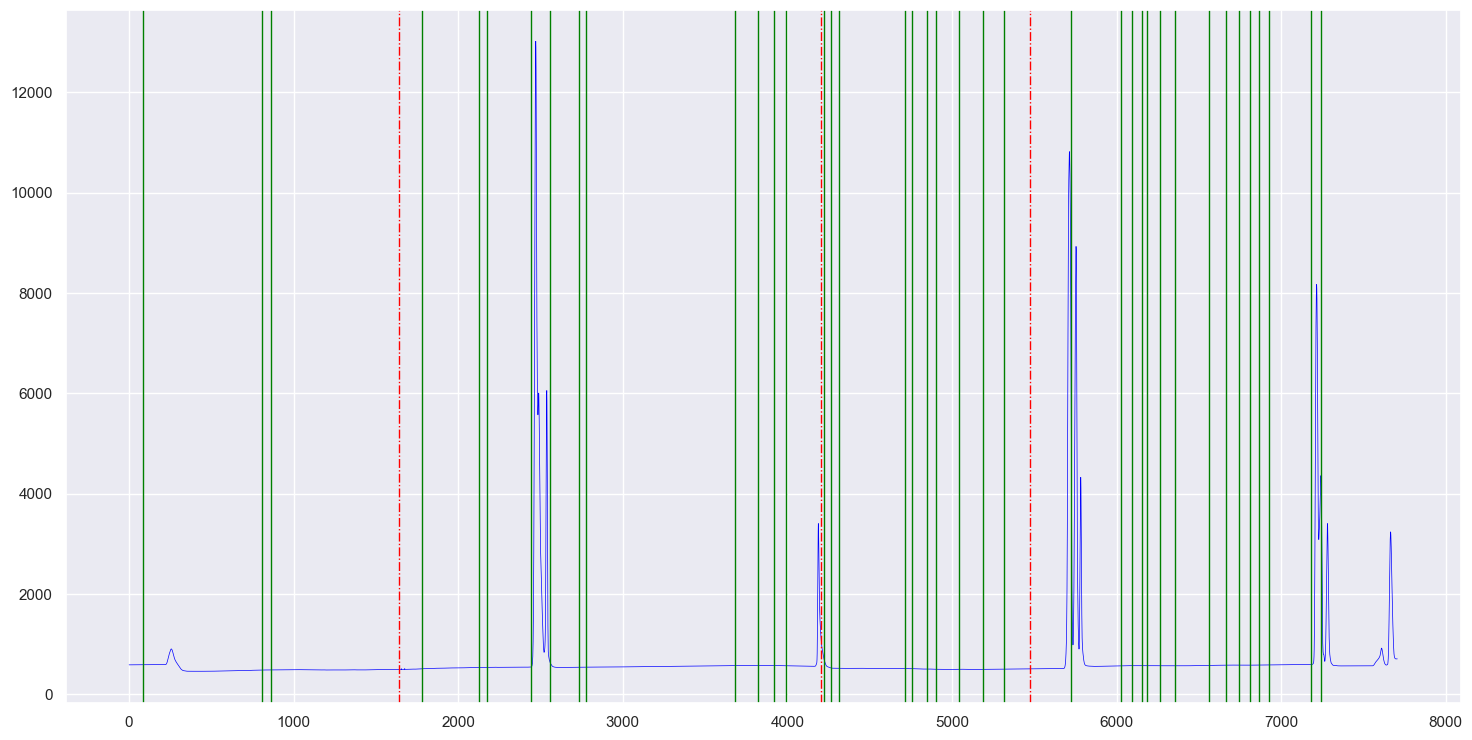

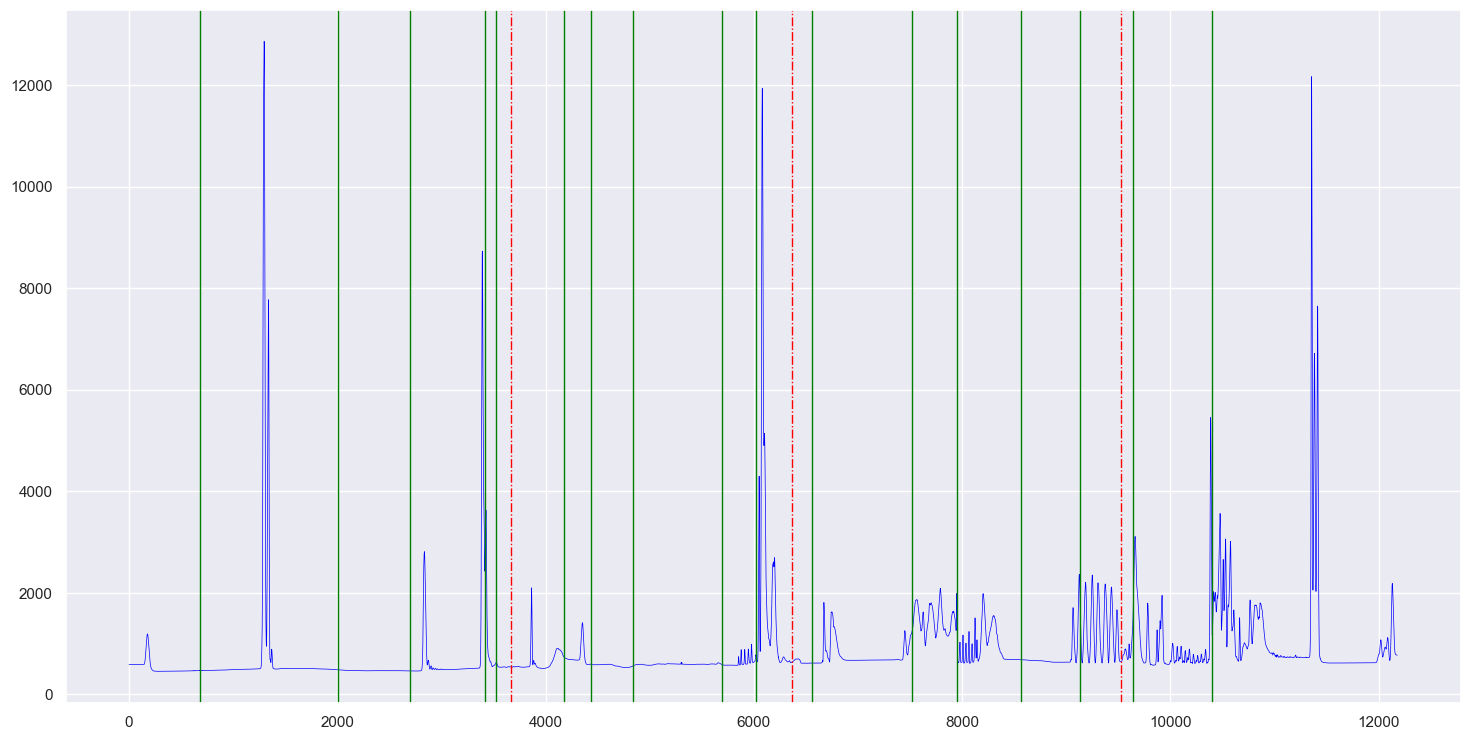

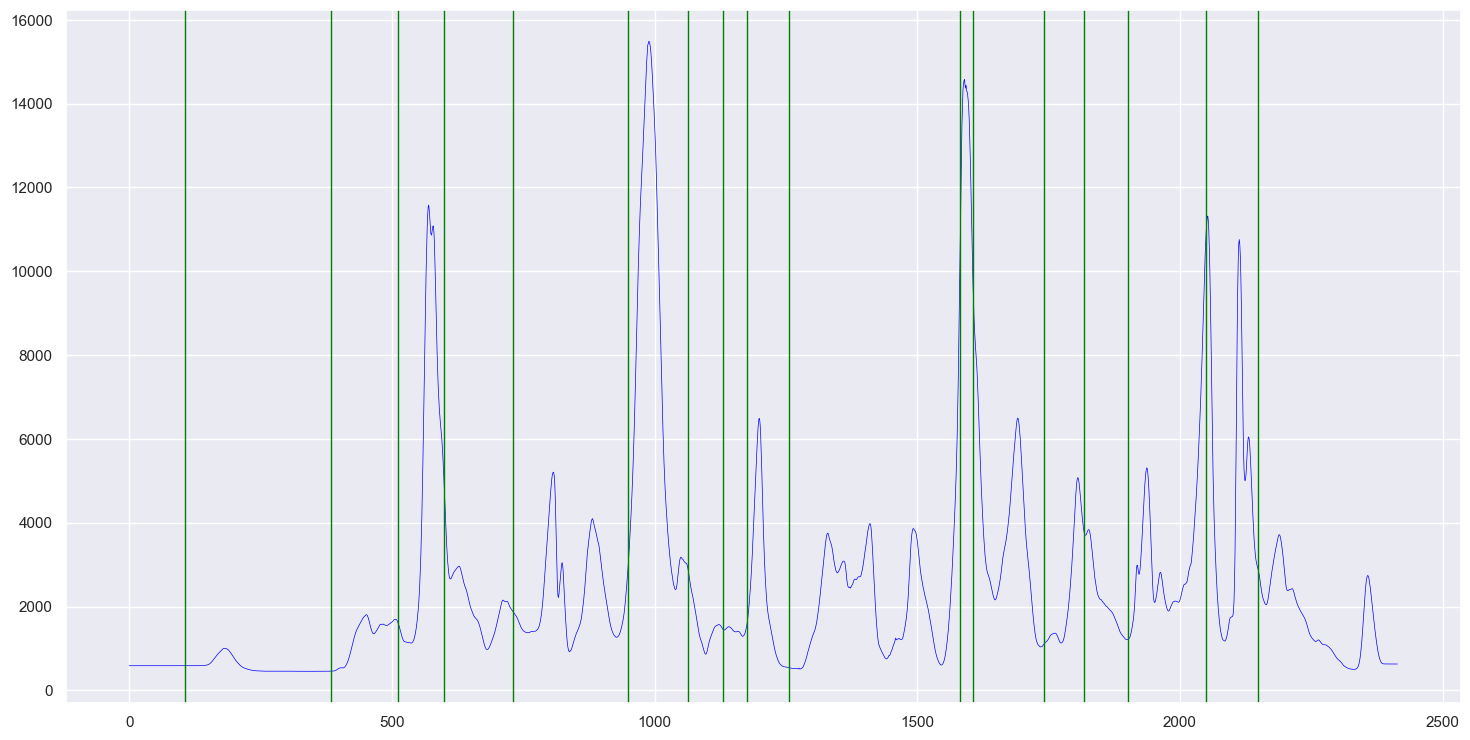

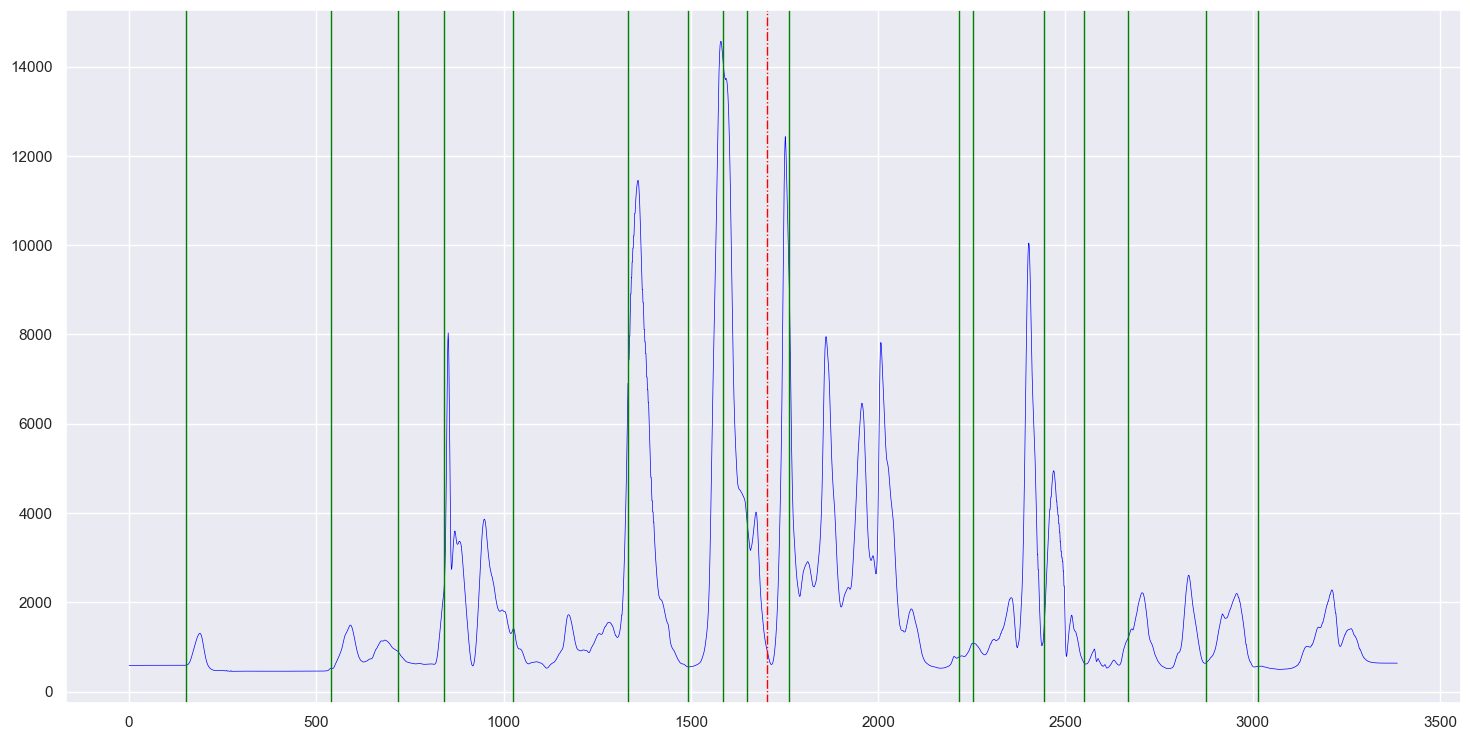

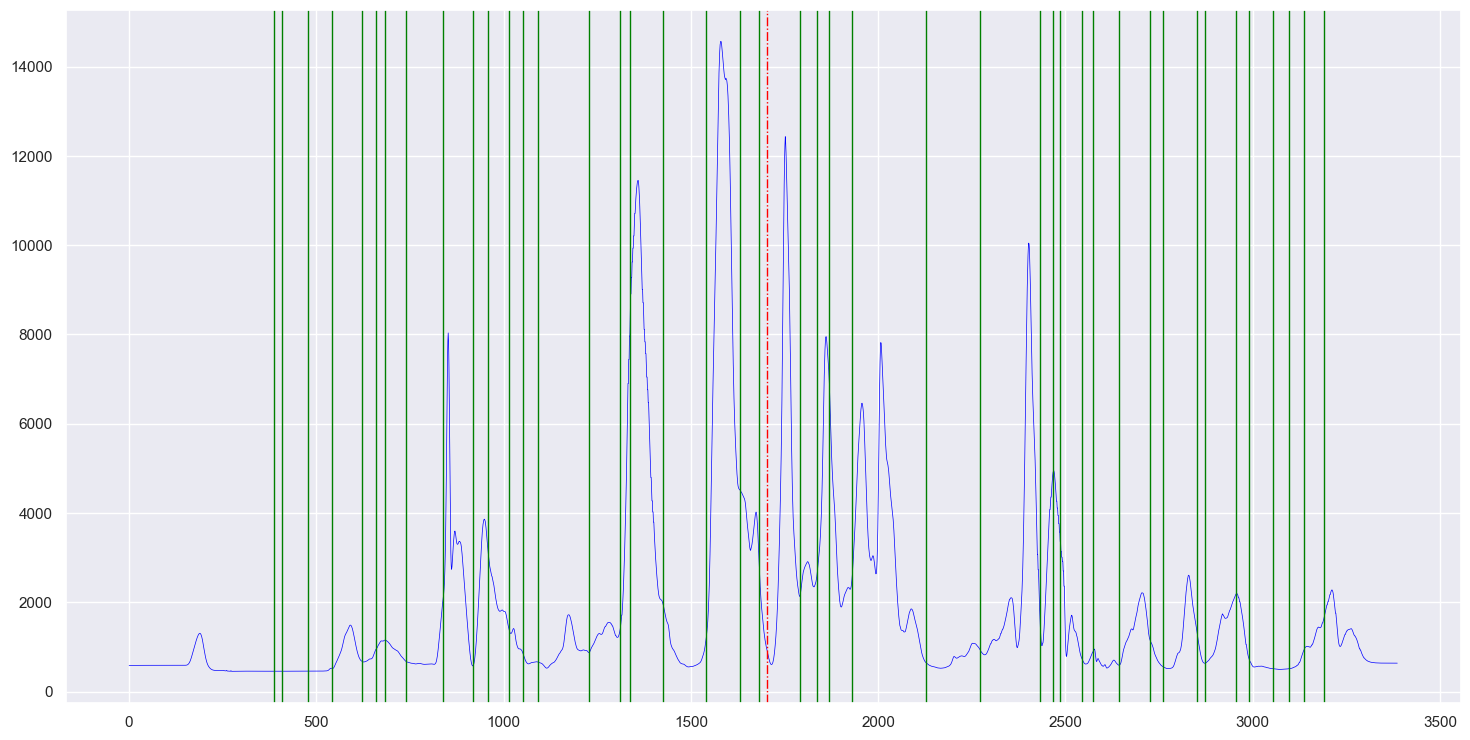

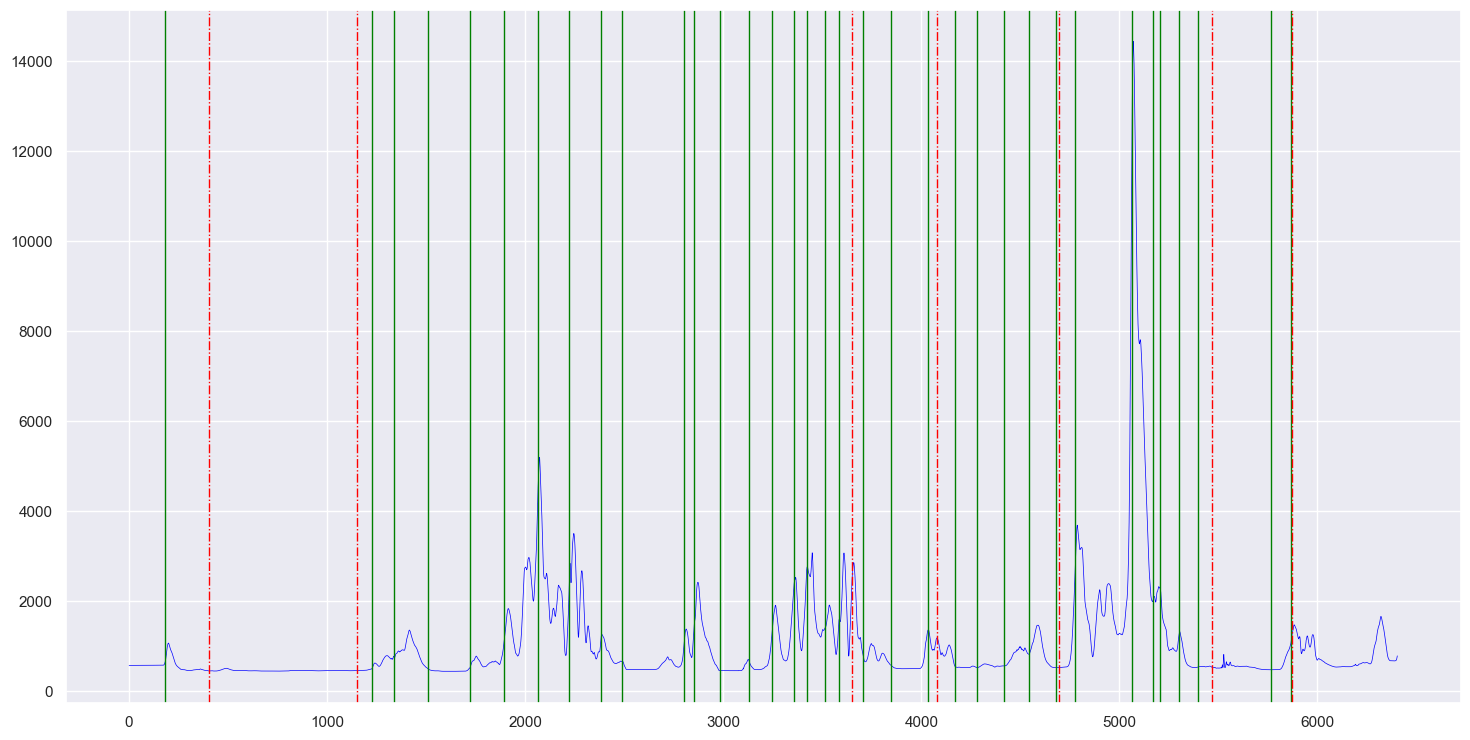

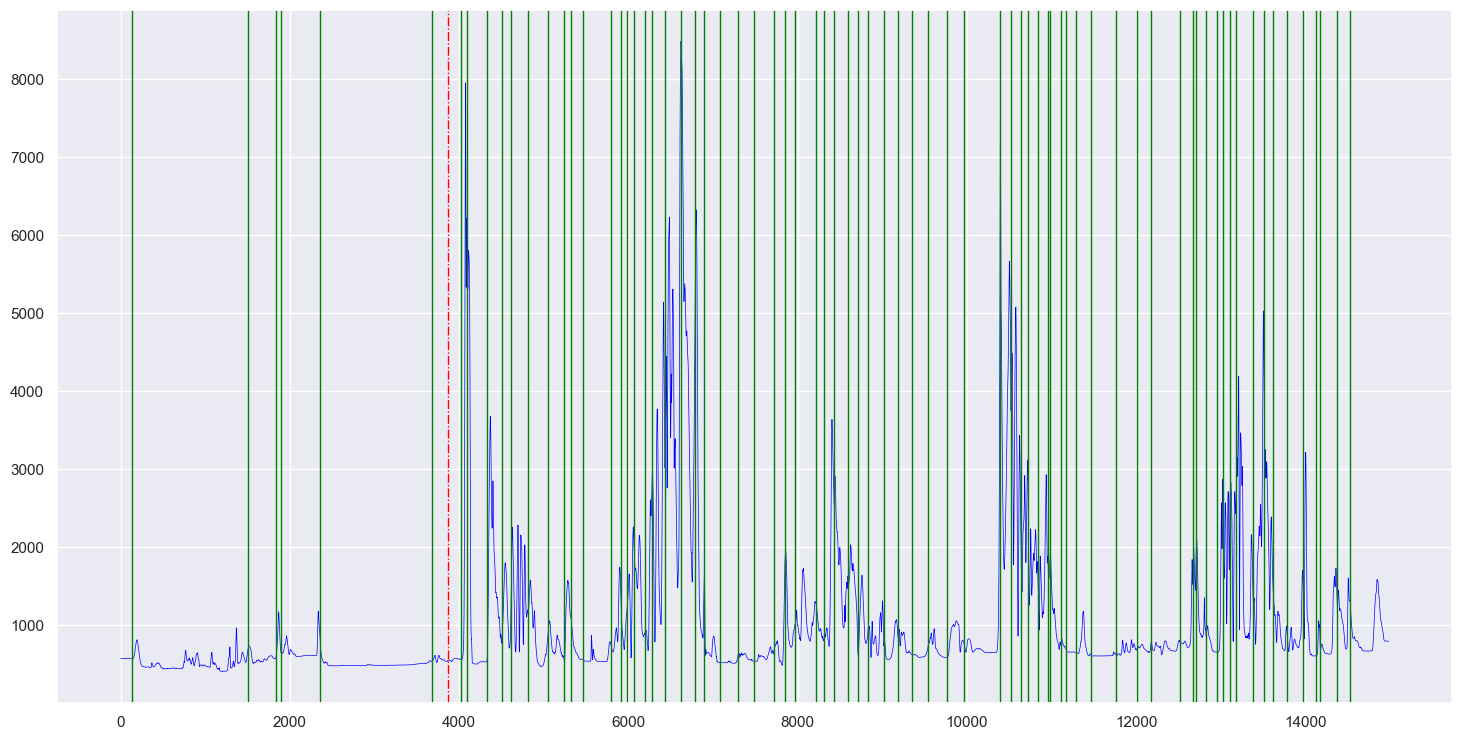

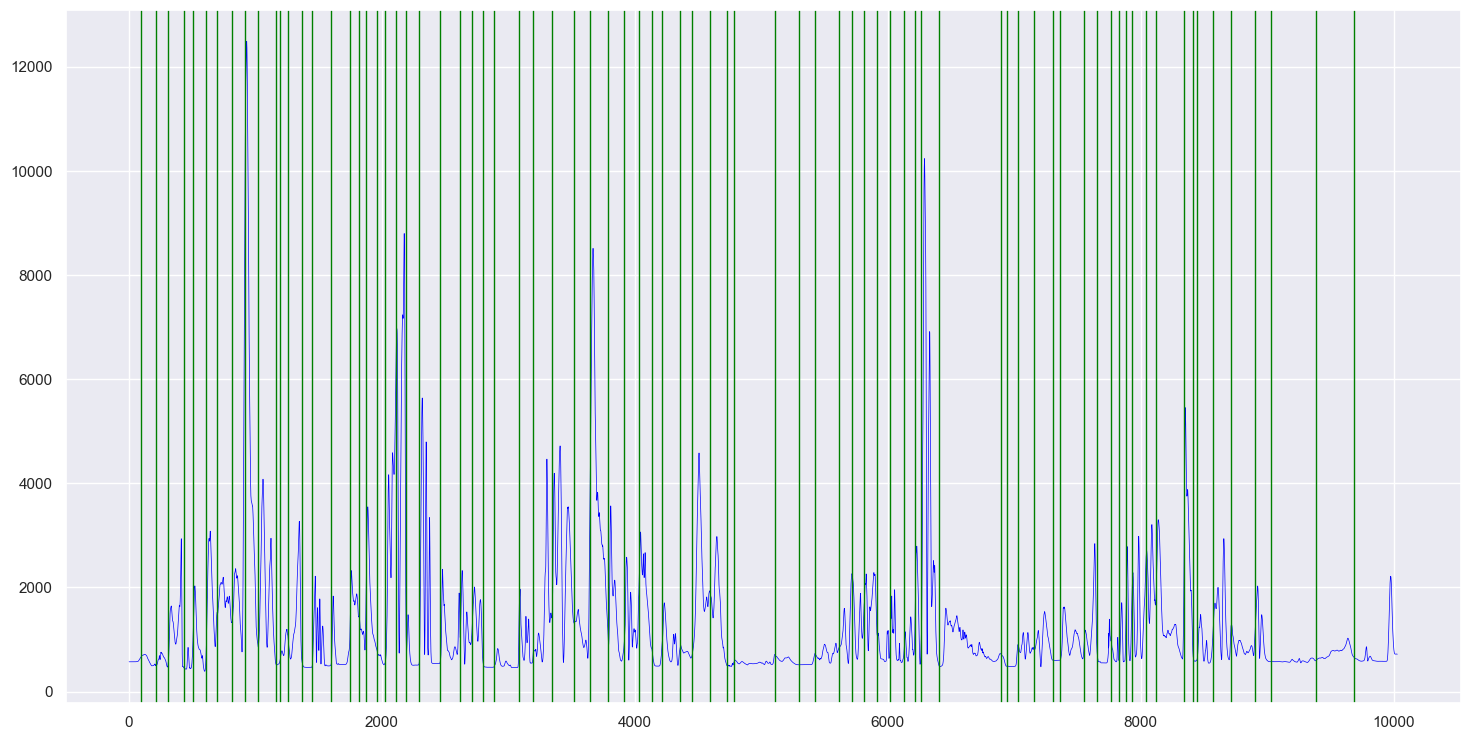

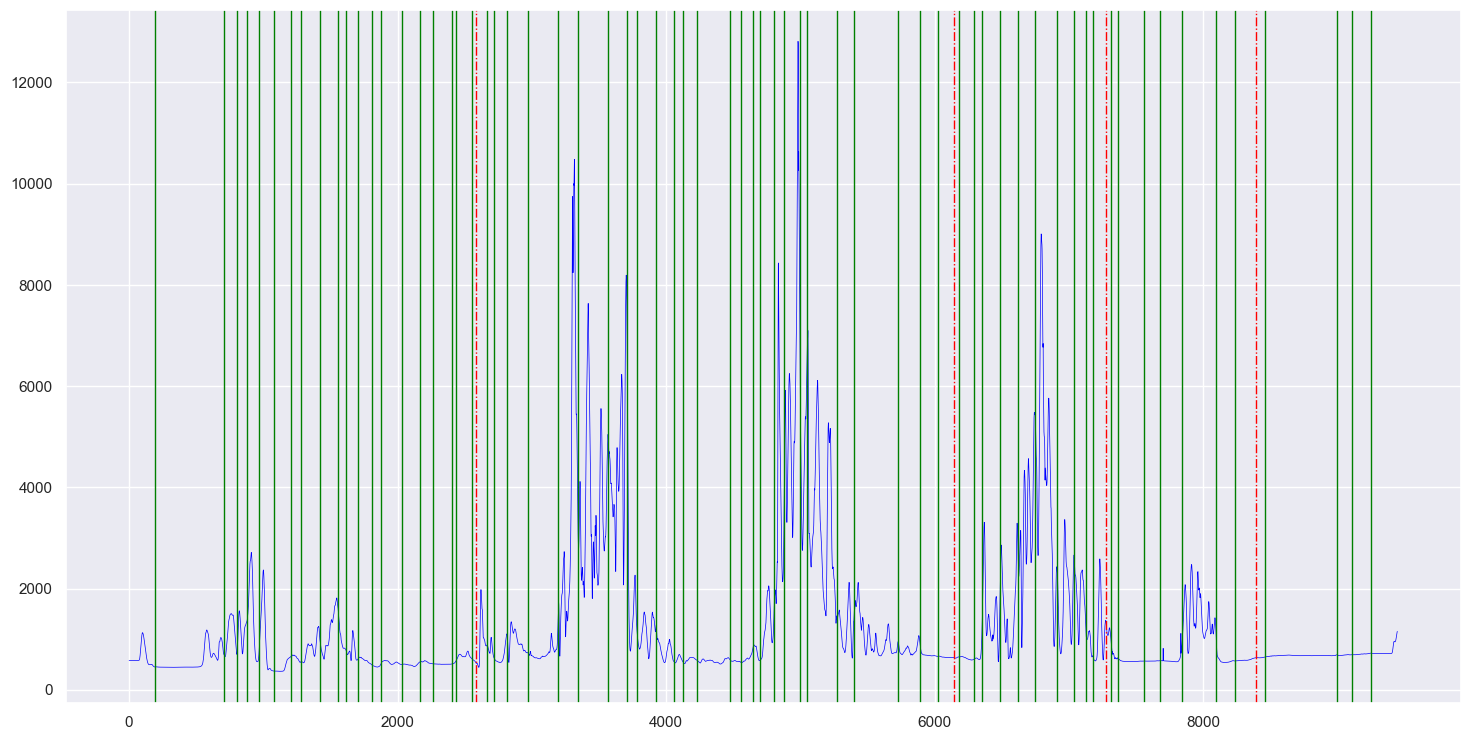

In [9]:
# suss
for i in range(len(timeseries)):
    print(i)
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0)
    Plotclasp(clasp,gt,100,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100,"suss",timeseries[i])

In [ ]:
# fft
for i in range(len(timeseries)):
    print(i)
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,window_size="fft")
    Plotclasp(clasp,gt,100,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100,"fft",timeseries[i])

In [ ]:
# acf
for i in range(len(timeseries)):
    print(i)
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,window_size="acf")
    Plotclasp(clasp,gt,100,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100,"acf",timeseries[i])

In [ ]:
# suss, euclidean
for i in range(len(timeseries)):
    print(i)
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,window_ze="suss", distance="euclidean_distance")
    Plotclasp(clasp,gt,100,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100,"suss euclidean",timeseries[i])

In [ ]:
# fft, euclidean
for i in range(len(timeseries)):
    print(i)
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,window_ze="fft", distance="euclidean_distance")
    Plotclasp(clasp,gt,100,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100,"fft euclidean",timeseries[i])

In [ ]:
# acf, euclidean
for i in range(len(timeseries)):
    print(i)
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,window_ze="acf", distance="euclidean_distance")
    Plotclasp(clasp,gt,100,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100,"acf euclidean",timeseries[i])

In [ ]:
# suss, euclidean, 4
for i in range(len(timeseries)):
    print(i)
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,window_ze="suss", distance="euclidean_distance", excl_radius=4)
    Plotclasp(clasp,gt,100,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100,"suss euclidean 4 ",timeseries[i])

In [ ]:
# fft, euclidean, 4
for i in range(len(timeseries)):
    print(i)
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,window_ze="fft", distance="euclidean_distance", excl_radius=4)
    Plotclasp(clasp,gt,100,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100,"fft euclidean 4 ",timeseries[i])

In [ ]:
# acf, euclidean, 4
for i in range(len(timeseries)):
    print(i)
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0,window_ze="acf", distance="euclidean_distance", excl_radius=4)
    Plotclasp(clasp,gt,100,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df,100,"acf euclidean 4 ",timeseries[i])